# Detecting a Tesla Model
by: Cedomir Charlie Spalevic

By using the FastAI library, I want to see if I can create a model that can detect a Tesla model

In [1]:
from fastai.vision import *

I used the [icrawler](https://icrawler.readthedocs.io/en/latest/index.html) library to get images on the Tesla models. I got ~450 of the Model S, 3, X Y

In [ ]:
from icrawler.builtin import BingImageCrawler # Google Image Crawler isn't working :(

models = [
    "Tesla Model S",
    "Tesla Model 3",
    "Tesla Model X",
    "Tesla Model Y"
]

for model in models:
    storage = {
        "backend": "FileSystem",
        "root_dir": f"data/{model}"
    }
    crawler = BingImageCrawler(storage=storage)
    crawler.crawl(keyword=model, max_num=500)

## View Data

In [14]:
path = Path("data")
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
         ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)

In [15]:
data.classes

['Tesla Model 3', 'Tesla Model S', 'Tesla Model X', 'Tesla Model Y']

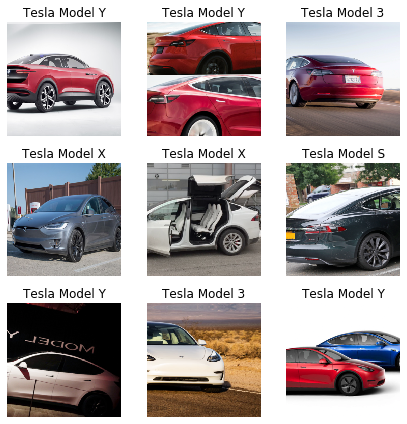

In [16]:
data.show_batch(rows=3, figsize=(6,6))

## Train model

In [29]:
# For shits n gigs lets see what resnet 50 can do
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [33]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time


RuntimeError: CUDA out of memory. Tried to allocate 38.00 MiB (GPU 0; 7.93 GiB total capacity; 5.35 GiB already allocated; 46.31 MiB free; 100.77 MiB cached)

Alright so not exactly the results we want. It looks like we're underfitting right now. Maybe we need some more data? Let's try looking at the learning rate

In [20]:
learn.save('stage-1')

In [21]:
learn.unfreeze()

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


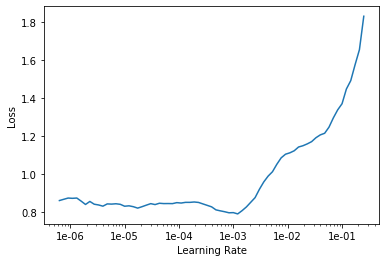

In [23]:
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.902316,0.862386,0.323864,00:48
1,0.801446,0.808278,0.303977,00:47


Alright getting better! But I would like that error rate to get higher. I actually do not know how to solve this. But let's see what we're getting wrong

In [25]:
learn.save('stage-2')

## Interpretation

In [26]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (1412 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Tesla Model Y,Tesla Model Y,Tesla Model Y,Tesla Model Y,Tesla Model Y
Path: data;

Valid: LabelList (352 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Tesla Model X,Tesla Model Y,Tesla Model 3,Tesla Model 3,Tesla Model X
Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1

In [27]:
interp = ClassificationInterpretation.from_learner(learn)

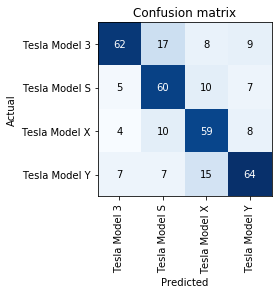

In [28]:
interp.plot_confusion_matrix()